# Rank Funding Agencies

## Years: 2008-2018

In [27]:
import time
import requests
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

import matplotlib as mpl
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
mpl.style.use('seaborn-muted')
sns.set(style='whitegrid')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from py2neo import Graph, Node, Relationship

years = '[2008 : 2018]'
grants_data_dir = "grants"

In [3]:
import requests

#   The credentials to be used
login = {
    'username': 'jww@mit.edu',
    'password': 'e38qDkG$tJ'
}

#   Send credentials to login url to retrieve token. Raise
#   an error, if the return code indicates a problem.
#   Please use the URL of the system you'd like to access the API
#   in the example below.
resp_auth = requests.post('https://app.dimensions.ai/api/auth.json', json=login)
resp_auth.raise_for_status()

#   Create http header using the generated token.
headers = {
    'Authorization': "JWT " + resp_auth.json()['token']
}

In [4]:
# long numbers to human readable string
def human_format(num):
    try:
        num = float('{:.3g}'.format(float(num)))
        magnitude = 0
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
    except:
        return num

In [5]:
from requests.exceptions import HTTPError
def dimensions_to_df(query):
    try:
        resp = requests.post(
            'https://app.dimensions.ai/api/dsl.json',
            data=query.encode(),
            headers=headers)
        resp.raise_for_status()
    except HTTPError as http_err:
        print('Error while executing query: ', query)
        raise http_err
    ret = resp.json()
    keys = list(ret.keys())
    keys.remove('_stats')
    if len(keys):
        df = pd.DataFrame(ret[keys[0]])
    else:
        df = pd.DataFrame()
    return df, ret['_stats']

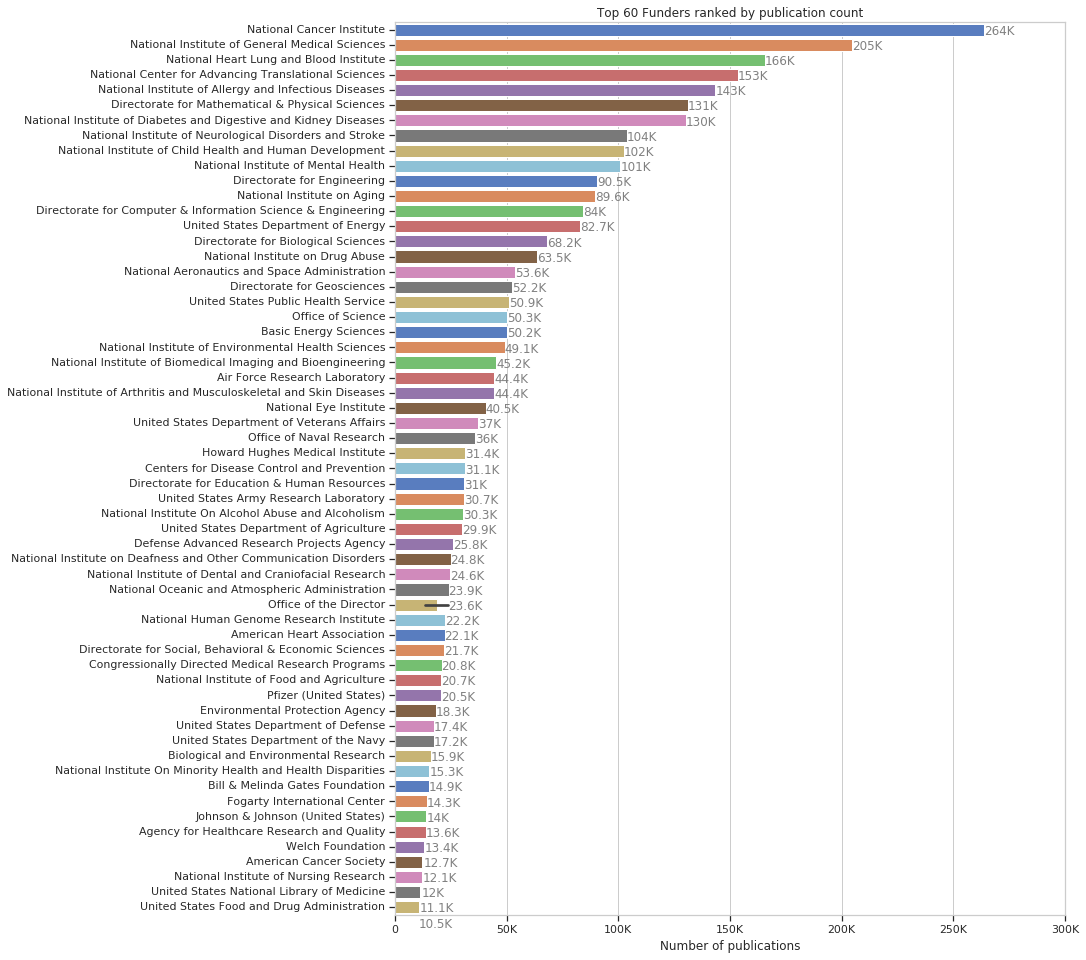

In [90]:
# US Funders ranked by number of publications

query = (
    'search publications ' +
    'where funder_countries = "US" ' +
    'and year in ' + years + 
    ' return funders limit 300')
df, stats = dimensions_to_df(query)
only_us = df[df['country_name'] == 'United States'].head(60).reset_index()


fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "count", data=only_us, orient="h", palette="muted")
ax.set_title('Top 60 Funders ranked by publication count')
ax.set_ylabel('')
ax.set_xlabel('Number of publications')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
for index, row in only_us.iterrows():
    ax.text(row['count'], index + 0.33, human_format(row['count']), color='gray')
plt.show()

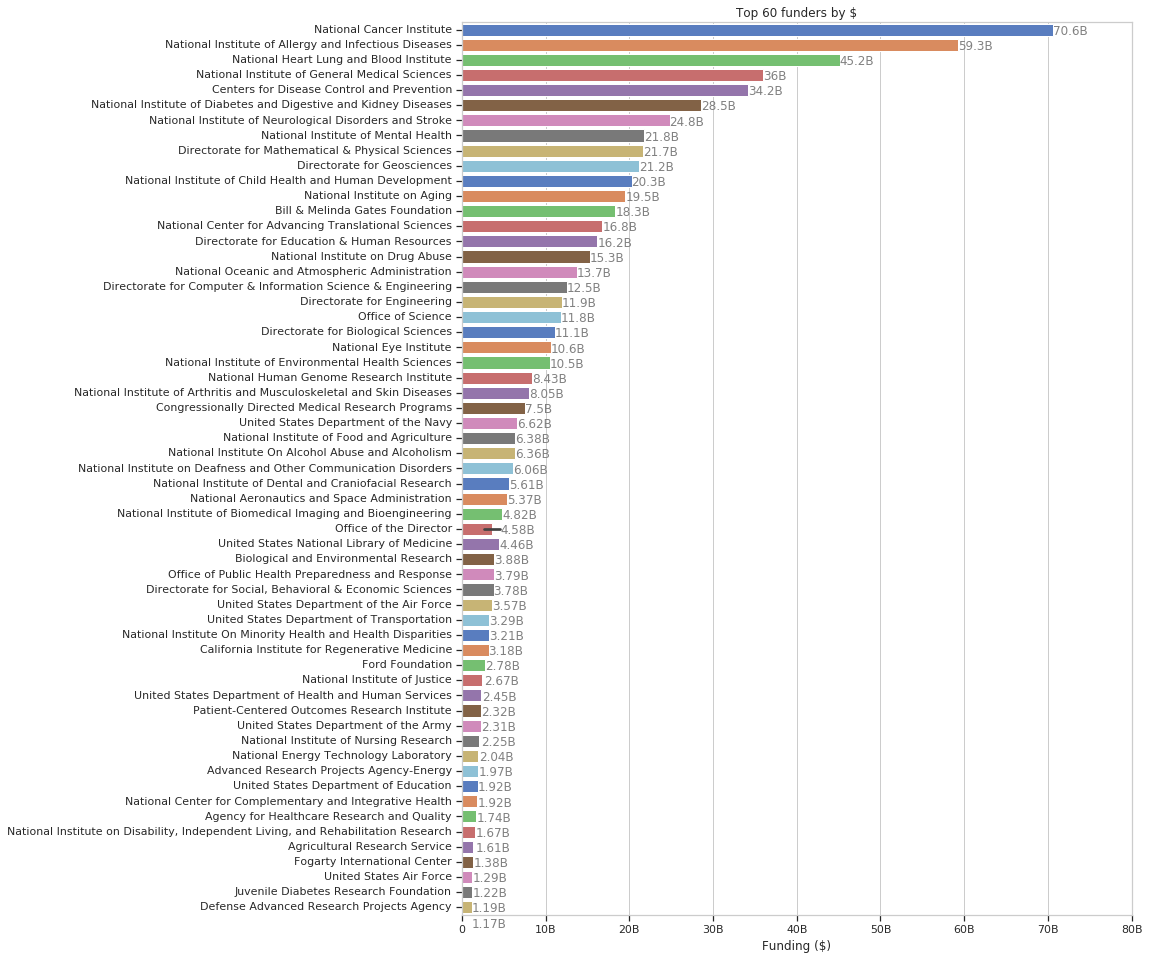

In [95]:
# US funders ranked by funding amount

query = (
    'search grants ' +
    'where funder_countries = "US" ' +
    'and active_year in ' + years + 
    ' return funders ' +
    'aggregate funding ' +
    'sort by funding desc limit 300')
df, stats = dimensions_to_df(query)
only_us = df[df['country_name'] == 'United States'].head(60).reset_index()
top100 = df[df['country_name'] == 'United States'].head(100).reset_index()
over100m = df[df['country_name'] == 'United States']
over100m = df[df['funding'] > 1e8]


fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "funding", data=only_us, orient="h", palette="muted")
ax.set_title('Top 60 funders by $')
ax.set_ylabel('')
ax.set_xlabel('Funding ($)')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
for index, row in only_us.iterrows():
    ax.text(row['funding'], index + 0.33, human_format(row['funding']), color='gray')
plt.show()

In [26]:
# Fetch all grants for all top 100 funders

for index, row in top100.iterrows(): 
    print("Fetching grants for #%d - %s" % (index, row['name']))
    query = (
        'search grants ' +
        'where funders.name = "' + row['name'] + '" ' + 
        'and active_year in ' + years + 
        'return grants [all - abstract - original_title] ' + 
        'sort by id ' +
        'limit 1000 skip '
    )

    big_df, stats = dimensions_to_df(query + "0")
    total = stats['total_count']

    if total > 50000:
        raise Exception("Total number of grants for this funder exceeds the maximum fetch-able amount", total)

    start = 1
    step = 1000
    idx = start
    for i in range(start * step, total, step):
        time.sleep(2)
        print("%.1f%%" % (float(i) * 100 / total))
        df, stats = dimensions_to_df(query + "%d" % i)
        big_df = pd.concat([big_df, df])
        
    filename = "%s/%s.csv" % (grants_data_dir, row['acronym'])
    big_df.to_csv(filename)
    print("Done. Saved to " + filename)

print("ALL Done.")

Fetching grants for #0 - National Cancer Institute
3.0%
5.9%
8.9%
11.8%
14.8%
17.7%
20.7%
23.6%
26.6%
29.5%
32.5%
35.4%
38.4%
41.3%
44.3%
47.2%
50.2%
53.1%
56.1%
59.0%
62.0%
64.9%
67.9%
70.8%
73.8%
76.7%
79.7%
82.6%
85.6%
88.5%
91.5%
94.5%
97.4%
Done. Saved to grants//NCI.csv
Fetching grants for #1 - National Institute of Allergy and Infectious Diseases
3.5%
7.0%
10.5%
14.0%
17.5%
21.0%
24.5%
27.9%
31.4%
34.9%
38.4%
41.9%
45.4%
48.9%
52.4%
55.9%
59.4%
62.9%
66.4%
69.9%
73.4%
76.9%
80.4%
83.8%
87.3%
90.8%
94.3%
97.8%
Done. Saved to grants//NIAID.csv
Fetching grants for #2 - National Heart Lung and Blood Institute
4.4%
8.9%
13.3%
17.7%
22.1%
26.6%
31.0%
35.4%
39.8%
44.3%
48.7%
53.1%
57.5%
62.0%
66.4%
70.8%
75.3%
79.7%
84.1%
88.5%
93.0%
97.4%
Done. Saved to grants//NHLBI.csv
Fetching grants for #3 - National Institute of General Medical Sciences
5.3%
10.6%
15.8%
21.1%
26.4%
31.7%
37.0%
42.2%
47.5%
52.8%
58.1%
63.4%
68.6%
73.9%
79.2%
84.5%
89.8%
95.0%
Done. Saved to grants//NIGMS.csv
Fetch

Done. Saved to grants//NETL.csv
Fetching grants for #50 - United States Department of Education
Done. Saved to grants//DoED.csv
Fetching grants for #51 - Advanced Research Projects Agency-Energy
Done. Saved to grants//ARPA-E.csv
Fetching grants for #52 - National Center for Complementary and Integrative Health
67.8%
Done. Saved to grants//NCCIH.csv
Fetching grants for #53 - Agency for Healthcare Research and Quality
40.0%
80.1%
Done. Saved to grants//AHRQ.csv
Fetching grants for #54 - National Institute on Disability, Independent Living, and Rehabilitation Research
93.5%
Done. Saved to grants//NIDILRR.csv
Fetching grants for #55 - Agricultural Research Service
42.6%
85.1%
Done. Saved to grants//ARS.csv
Fetching grants for #56 - Fogarty International Center
80.3%
Done. Saved to grants//FIC.csv
Fetching grants for #57 - United States Air Force
43.1%
86.2%
Done. Saved to grants//USAF.csv
Fetching grants for #58 - Juvenile Diabetes Research Foundation
45.2%
90.4%
Done. Saved to grants//JDR

In [ ]:
import os

for filename in os.listdir(grants_data_dir):
    if filename.endswith(".csv"): 
        acronym, _ = os.path.splitext(filename)
        if acronym == "Alfred P. Sloan Foundation":
            row = top100[top100['name'] == acronym].to_dict('records')[0]
        else:
            row = top100[top100['acronym'] == acronym].to_dict('records')[0]
        print("Calculating metrics for ", row['name'])
        df = pd.read_csv('%s/%s' % (grants_data_dir, filename))
        # do something with the data

In [97]:
names = ['"%s"' % s for s in over100m['name']]

query = (
    'search publications ' +
    'where funders.name in [' + ','.join(names) + '] ' + 
    'and year in ' + years + 
    ' return funders ' + 
    'aggregate count, citations_total, citations_avg, altmetric_median, rcr_avg, fcr_gavg ' +
    'limit 1000'
)
df, stats = dimensions_to_df(query)
metrics = df[df['name'].isin(over100m['name'])]

In [98]:
new_df = pd.merge(over100m[['name', 'funding', 'count']], metrics, on='name')
new_df.rename(columns={'count_x':'count_grants',
                                'count_y':'count_publications'},inplace=True)
new_df

,name,funding,count_grants,acronym,altmetric_median,citations_avg,citations_total,count_publications,country_name,fcr_gavg,id,rcr_avg
0,National Cancer Institute,7.063250e+10,33125,NCI,3.000000,39.381656,10397466.0,264018,United States,3.035487,grid.48336.3a,1.870468
1,National Institute of Allergy and Infectious D...,5.927476e+10,28634,NIAID,3.000000,35.616814,5109410.0,143455,United States,2.802553,grid.419681.3,1.797866
2,National Heart Lung and Blood Institute,4.515525e+10,22594,NHLBI,3.000000,35.322561,5853125.0,165705,United States,3.227454,grid.279885.9,1.812376
3,National Institute of General Medical Sciences,3.599162e+10,18946,NIGMS,3.000000,37.312189,7642693.0,204831,United States,2.823180,grid.280785.0,1.762013
4,Centers for Disease Control and Prevention,3.416329e+10,10578,CDC,3.000000,24.250369,755205.0,31142,United States,2.489146,grid.416738.f,1.744581
5,National Institute of Diabetes and Digestive a...,2.853167e+10,16115,NIDDK,3.000000,39.015762,5084183.0,130311,United States,3.289279,grid.419635.c,1.995531
6,National Institute of Neurological Disorders a...,2.479693e+10,16684,NINDS,3.000000,39.318618,4081941.0,103817,United States,3.198284,grid.416870.c,1.973860
7,National Institute of Mental Health,2.175291e+10,13542,NIMH,3.000000,38.607404,3894908.0,100885,United States,3.647890,grid.416868.5,2.081947
8,Directorate for Mathematical & Physical Sciences,2.168878e+10,36979,NSF MPS,2.000000,23.580710,3088908.0,130993,United States,2.655723,grid.457875.c,1.274380
9,Directorate for Geosciences,2.120403e+10,24944,NSF GEO,3.000000,25.093975,1309780.0,52195,United States,2.834077,grid.457836.b,1.218894


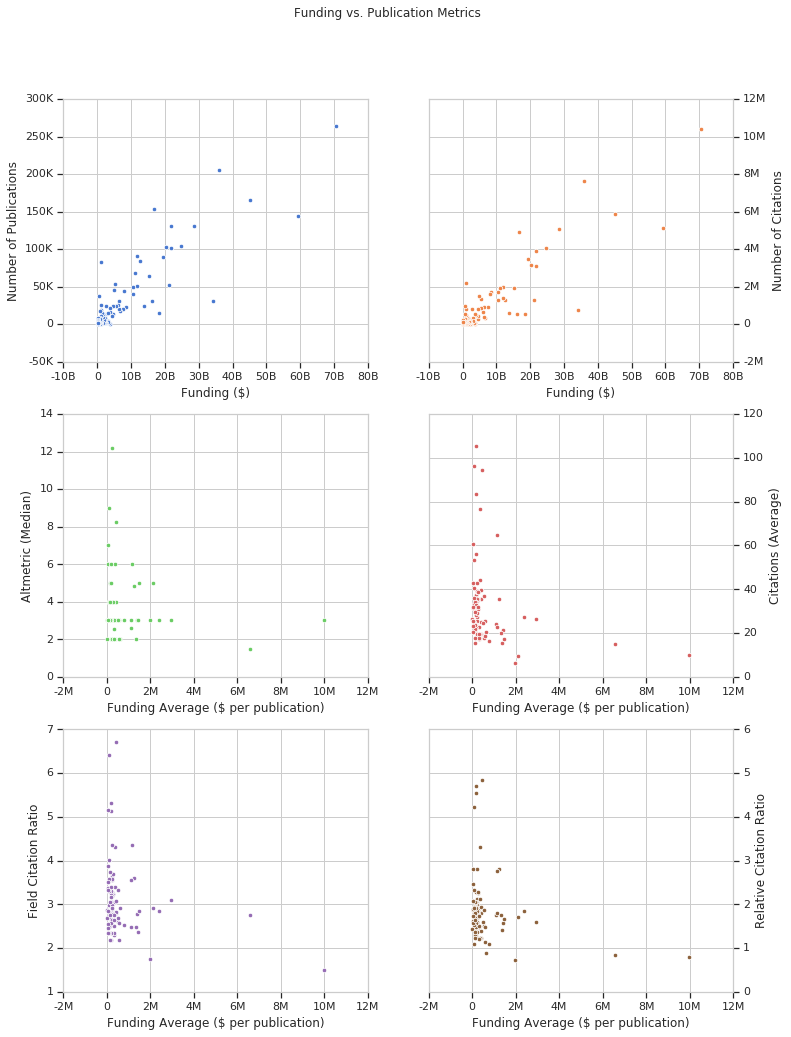

In [103]:
fig, axes = plt.subplots(3, 2, figsize=(12,16))
fig.suptitle('Funding vs. Publication Metrics') 
colors = np.array(sns.color_palette("muted"))

new_df["funding_avg"] = new_df["funding"] / new_df["count_publications"]

sns.scatterplot(ax = axes[0][0], x="funding", y="count_publications", data=new_df, color=colors[0])
axes[0][0].set_ylabel('Number of Publications')
axes[0][0].yaxis.tick_left()
axes[0][0].set_yticklabels([human_format(tick) for tick in axes[0][0].get_yticks().tolist()])
sns.scatterplot(ax = axes[0][1], x="funding", y="citations_total", data=new_df, color=colors[1])
axes[0][1].set_ylabel('Number of Citations')
axes[0][1].yaxis.set_label_position("right")
axes[0][1].yaxis.tick_right()
axes[0][1].set_yticklabels([human_format(tick) for tick in axes[0][1].get_yticks().tolist()])
sns.scatterplot(ax = axes[1][0], x="funding_avg", y="altmetric_median", data=new_df, color=colors[2])
axes[1][0].set_ylabel('Altmetric (Median)')
axes[1][0].yaxis.tick_left()
axes[1][0].set_yticklabels([human_format(tick) for tick in axes[1][0].get_yticks().tolist()])
sns.scatterplot(ax = axes[1][1], x="funding_avg", y="citations_avg", data=new_df, color=colors[3])
axes[1][1].set_ylabel('Citations (Average)')
axes[1][1].yaxis.set_label_position("right")
axes[1][1].yaxis.tick_right()
axes[1][1].set_yticklabels([human_format(tick) for tick in axes[1][1].get_yticks().tolist()])
sns.scatterplot(ax = axes[2][0], x="funding_avg", y="fcr_gavg", data=new_df, color=colors[4])
axes[2][0].set_ylabel('Field Citation Ratio')
axes[2][0].yaxis.tick_left()
axes[2][0].set_yticklabels([human_format(tick) for tick in axes[2][0].get_yticks().tolist()])
sns.scatterplot(ax = axes[2][1], x="funding_avg", y="rcr_avg", data=new_df, color=colors[5])
axes[2][1].set_ylabel('Relative Citation Ratio')
axes[2][1].yaxis.set_label_position("right")
axes[2][1].yaxis.tick_right()
axes[2][1].set_yticklabels([human_format(tick) for tick in axes[2][1].get_yticks().tolist()])

for i in range(len(axes)):
    for ax in axes[i]:
        ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
        if i == 0:
            ax.set_xlabel('Funding ($)')
        else:
            ax.set_xlabel('Funding Average ($ per publication)')
        ax.xaxis.tick_bottom()

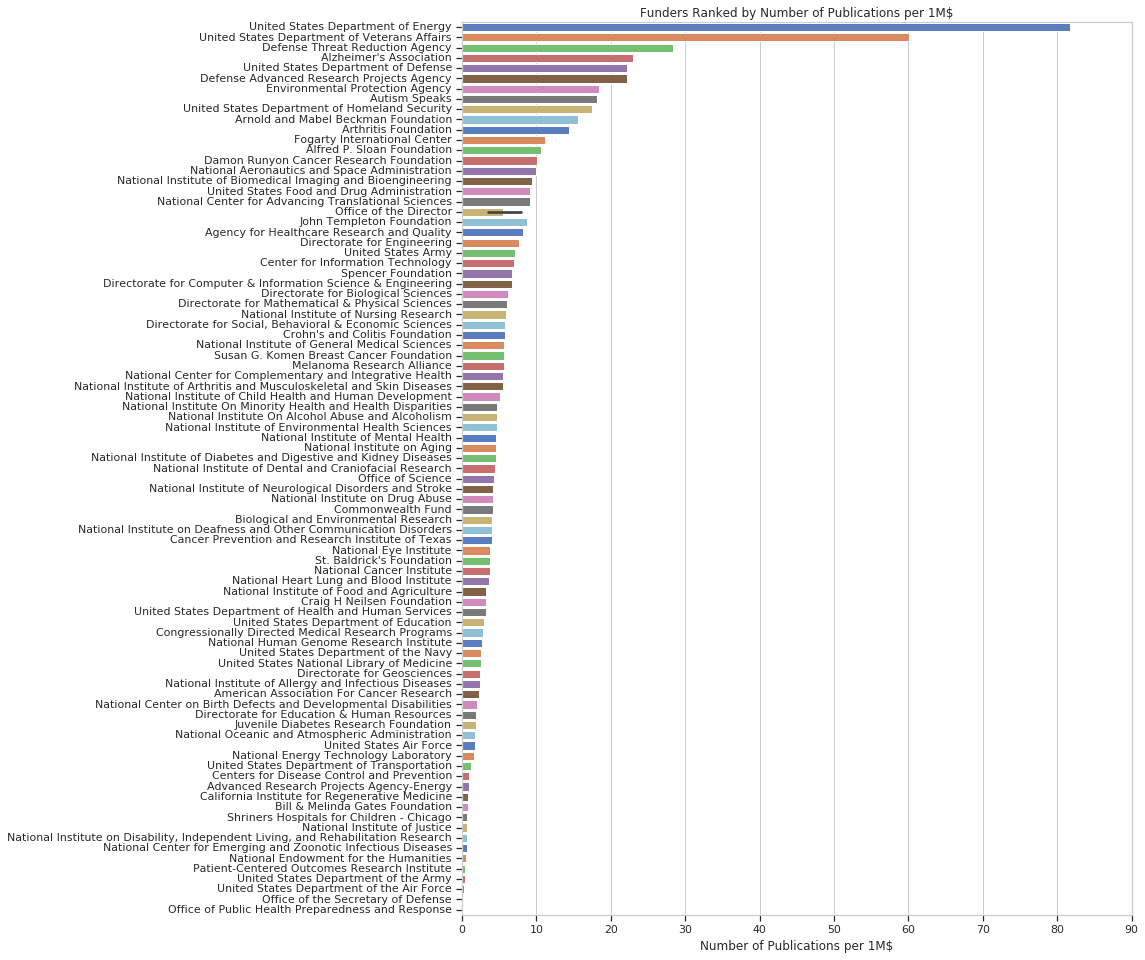

In [100]:
# Rank funders by publications per $
new_df['pub_per_$'] = new_df['count_publications'] * 1000000 / new_df['funding']

fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "pub_per_$", data=new_df.sort_values(by=['pub_per_$'], ascending=False), orient="h", palette="muted")
ax.set_title('Funders Ranked by Number of Publications per 1M$')
ax.set_ylabel('')
ax.set_xlabel('Number of Publications per 1M$')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
plt.show()

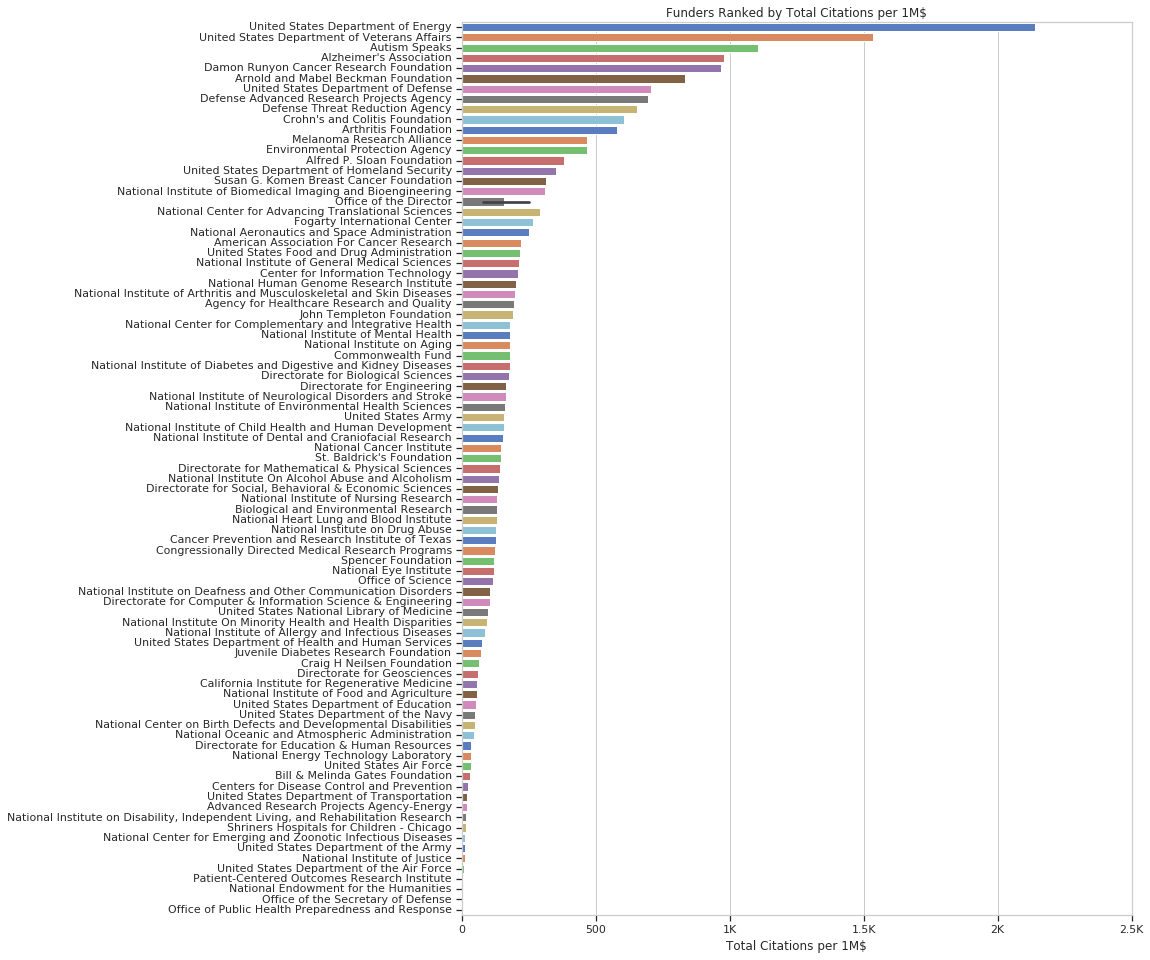

In [101]:
# Rank funders by publications per $
new_df['cite_total_per_$'] = new_df['citations_total'] * 1000000 / new_df['funding']

fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "cite_total_per_$", data=new_df.sort_values(by=['cite_total_per_$'], ascending=False), orient="h", palette="muted")
ax.set_title('Funders Ranked by Total Citations per 1M$')
ax.set_ylabel('')
ax.set_xlabel('Total Citations per 1M$')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
plt.show()